# JAL-AM

In [172]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from model_lib import *
#from JAL_AM_lib import *

In [347]:
def calculate_AV(Q, pi_other, state, k):
    AV = np.zeros(k)
    
    #print(Q,pi_other,state,k)
    for action in range(k):
        #for other_action in range(num_actions):
        
        AV[action] = Q[action, state] * pi_other[action,state]
    return AV

In [348]:
def update_agent_model(state, action, counter):
    """
    args:
        state: the current state of player j
        action: action of player j
        counter: array holding count of every action played in each state
    returns:
        counter: the updated counter
        agent_model: the updated agent model
    """
    counter[state, action] += 1
    # måske skal man opdatere alle agent models af gangen og ikke kun 1
    agent_model = counter[state, action] / np.sum(counter[state,:])
    return counter, agent_model

In [349]:
def select_price(j, t, p_table, Q_table, price_grid, epsilon,pi_other):
    """
    args:
        j: player 1
        t: current period
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table
        price_grid: price_grid
        epsilon: decay parameter of learning module
    returns:
        random price or maximized price
    """
    s_t_idx = np.where(price_grid == p_table[j, t-1])[0][0] # current state (opponent's price)
    AV = calculate_AV(Q_table, pi_other,s_t_idx, 7)
    # Exploration
    if epsilon >= np.random.uniform(0,1):
        return np.random.choice(price_grid)
    else:
    # Exploitation
        maxedQ_idx=np.argmax(AV)
        return price_grid[maxedQ_idx]

In [364]:
def Q_func(p_curr_idx, s_curr_idx, i, j, t, alpha, gamma, p_table, Q_table, price_grid, s_next,pi_other,T) -> float: # p_table contains p and s (opponent price)
    """
    args:
        p_curr_idx: current price of player i
        s_curr_idx: current state of player i
        i: player 0
        j: player 1
        t: current period
        alpha: step-size parameter
        gamma: discount factor
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table for player i
        price_grid: price_grid
        s_next: next state for player i
    returns:
        updated value for Q_table 
    """
    prev_est = Q_table[p_curr_idx, s_curr_idx]
    s_next_index=np.where(price_grid == s_next)[0][0]
    
    # Beregn de forventede Q-værdier ved at bruge AV
    AV = calculate_AV(Q_table, pi_other, s_next_index,7)
    
    # Vælg den handling for næste tilstand med den højeste AV-værdi
    best_next_action = np.argmax(AV)
    best_next_price=price_grid[best_next_action]
    
    # Beregn den forventede fremtidige værdi ved at bruge den valgte AV-værdi
    expected_future_value = profit(best_next_price, s_next)
    reward = profit(p_table[i, t], p_table[j, t-2])+gamma* expected_future_value+gamma**2* best_next_price
    # Opdater Q-værdien for den nuværende tilstand og handling
    return (1- alpha) * prev_est + alpha*(reward + gamma * expected_future_value - Q_table[p_curr_idx,s_curr_idx])


In [384]:
def JAL_AM(alpha, gamma, T, price_grid):
    # Initializing values
    epsilon = calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    k = len(price_grid)
    q1 = np.zeros((k, k)) 
    q2 = np.zeros((k, k)) 
    # Initializing policies
    Agent_model_1 = np.ones((k, k)) / k
    Agent_model_2 = np.ones((k, k)) / k

    # Initializing N, a counter
    N1 = np.zeros((k, k))
    N2 = np.zeros((k, k))
    
    # Initializing profits
    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []

    # Setting random price and state for t = 0
    p_table[i,t] = np.random.choice(price_grid)
    p_table[j,t] = np.random.choice(price_grid)
    
    t += 1
    # Setting random price and state for t = 1
    p_table[i,t] = np.random.choice(price_grid)
    p_table[j,t] = np.random.choice(price_grid)
    t += 1
    for t in range(t,T):
        #print("hey")
        p_table[i,t] = p_table[i,t-1]
        p_idx = np.where(price_grid == p_table[i,t])[0][0]
        s_next = p_table[j,t-1]
        current_state_idx = np.where(price_grid == p_table[j,t-2])[0][0]
        # opdatering af q skal vel flyttes længere ned?
        q1[p_idx, current_state_idx] = Q_func(p_idx, current_state_idx, i,j, t, alpha, gamma, p_table, q1, price_grid, s_next, Agent_model_2,T)

        p_table[i,t] = select_price(j, t, p_table, q1, price_grid, epsilon[t], Agent_model_2)
        p_table[j, t] = p_table[j, t-1]
        opponent_price = np.where(price_grid==p_table[j,t])[0][0]
        N2, Agent_model_2[current_state_idx, opponent_price]= update_agent_model(current_state_idx, opponent_price, N2)
        # Store profits for both firms
        profits[i, t] = profit(p_table[i,t], p_table[j,t])
        profits[j, t] = profit(p_table[j,t], p_table[i,t])

        
        
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)
        
        # changing agents
        print(Agent_model_1)
        tmp = i
        i = j
        j = tmp
        tmp=q1
        q1=q2
        q2=tmp
        Agent_model_1, Agent_model_2 = Agent_model_2, Agent_model_1
        N1,N2=N2,N1
    return p_table, avg_profs1, avg_profs2


In [385]:
k = np.linspace(0,1,7)
a, b, c = JAL_AM(0.3, 0.95, 500, k)

[[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]]
[[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [1.         0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]
 [0.14285714 0.

In [377]:
a

array([[0.66666667, 0.        , 1.        , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.        , 1.        , 1.        , ..., 0.5       , 0.5       ,
        0.5       ]])

In [378]:
b

[0.07488888888888888,
 0.06598611111111112,
 0.06681944444444446,
 0.06458333333333334,
 0.06640277777777778,
 0.06934722222222223,
 0.07027777777777779,
 0.06716666666666665,
 0.07004166666666668,
 0.07318055555555557,
 0.072125,
 0.07723611111111112,
 0.07523611111111111,
 0.06258333333333334,
 0.07547222222222223,
 0.07481944444444445,
 0.07755555555555556,
 0.07520833333333334,
 0.07233333333333333,
 0.074,
 0.06902777777777777,
 0.06536111111111112,
 0.07479166666666667,
 0.07608333333333332,
 0.08408333333333334,
 0.08761111111111111,
 0.08252777777777778,
 0.08023611111111112,
 0.08279166666666667,
 0.07894444444444446,
 0.07329166666666666,
 0.08365277777777778,
 0.084875,
 0.10506944444444445,
 0.08473611111111111,
 0.08093055555555556,
 0.09254166666666667,
 0.09036111111111111,
 0.08594444444444446,
 0.0895,
 0.07886111111111112,
 0.08506944444444446,
 0.08470833333333334,
 0.09326388888888891,
 0.07255555555555555,
 0.06438888888888888,
 0.07248611111111111,
 0.077055555555

In [379]:
c

[0.06877777777777777,
 0.078625,
 0.075125,
 0.07802777777777778,
 0.077375,
 0.07134722222222223,
 0.07241666666666667,
 0.07622222222222223,
 0.07154166666666666,
 0.06959722222222223,
 0.07243055555555555,
 0.07984722222222222,
 0.076125,
 0.08013888888888888,
 0.07544444444444445,
 0.071625,
 0.07680555555555557,
 0.07398611111111111,
 0.0805,
 0.07494444444444444,
 0.07266666666666667,
 0.07472222222222223,
 0.08398611111111111,
 0.08480555555555554,
 0.0871388888888889,
 0.0746388888888889,
 0.07997222222222222,
 0.07770833333333334,
 0.068625,
 0.08036111111111112,
 0.09206944444444444,
 0.07951388888888888,
 0.08034722222222222,
 0.06809722222222223,
 0.06215277777777778,
 0.08254166666666667,
 0.07648611111111112,
 0.07902777777777778,
 0.07863888888888888,
 0.07427777777777779,
 0.06555555555555556,
 0.06931944444444446,
 0.06898611111111111,
 0.07301388888888889,
 0.10266666666666667,
 0.08769444444444446,
 0.08481944444444446,
 0.09855555555555558,
 0.07936111111111112,
 0.

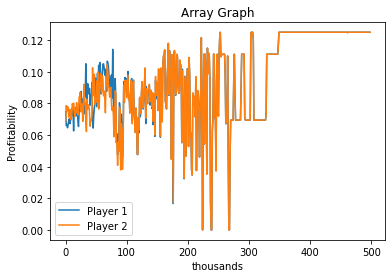

In [380]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, b)
plt.plot(x_values, c)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [381]:
def run_sim(n, k):
    """
    args:
        n: number of runs simulated
        k: length of price action vector
    returns:
        avg_avg_profitabilities: average of average profits over n simulations
    """
    num_calcs=int(500000/1000-1) # size of avg. profits 
    summed_avg_profitabilities = np.zeros(num_calcs)

    # simulating n runs of Klein_simulation
    for n in range(0, n):
        p_table, avg_profs1, avg_profs2 = JAL_AM(0.3, 0.95, 500000, k)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)

    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    return avg_avg_profitabilities

In [382]:
avg_prof= run_sim(100, np.linspace(0,1,7))

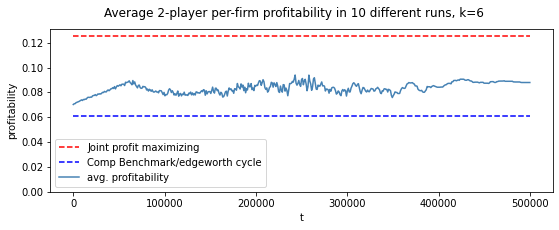

In [383]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()